# MAD 2018-19 Exam, template for Exercise 5: PCA and classification
This is a template for doing Exercise 5 on PCA and classification for the MAD 2018-19 Exam. Please fill out the fields and function templates below, reading the data as below, in order to perform the exercise. Feel free to load extra functions, but note that built-in functions for doing the entire task are, as a general rule, not allowed.

If you are unsure how to interpret the template, or what you are allowed to do, please contact us either by email or using the Absalon forum.

Feel free to add additional cells as needed.

In [16]:
# Importing packages -- feel free to add more, but recall that you should not use built-in 
# functions for the task at hand. If in doubt, ask us by email.
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (14, 7)

Before we get started, read the data as follows (assuming you have unpacked the dataset into a folder DD which sits in the same folder as the Jupyter notebook template):

In [17]:
trainset = np.loadtxt('DD/DD_train.txt')
testset = np.loadtxt('DD/DD_test.txt')
trainlabels = np.loadtxt('DD/DD_train_labels.txt')
testlabels = np.loadtxt('DD/DD_test_labels.txt')

# Since we have a feature where no object has relevant 
# values, we can remove it from the data
# We do this so that we do not divide by 0 in exercise 5f
trainset = np.delete(trainset, obj=17,axis=1)
testset = np.delete(testset, obj=17,axis=1)

**Exercise a:** In the cell below, please include your code for performing PCA and visualizing the dataset through projection onto the first two principal components.

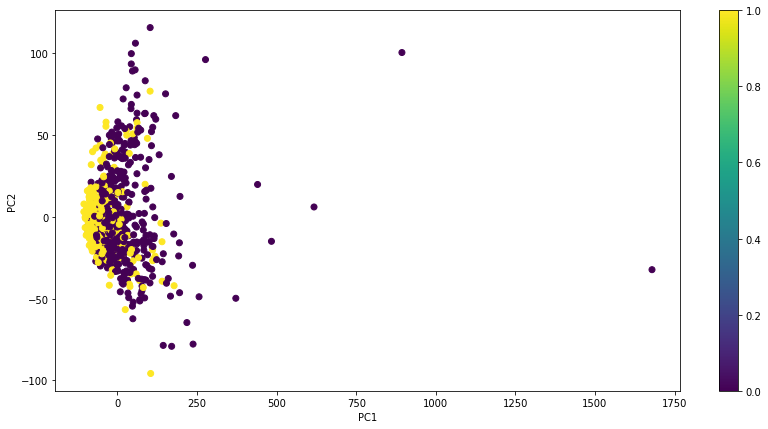

In [18]:
# This function has been taken from the lecture slides and modified slightly
def pca(data):
    # Extract data dimensions
    d, N = data.shape
    # First, center the data
    center = np.mean(data, 1)
    centers = np.matlib.repmat(center, N, 1)
    data_cent = data - np.transpose(centers)
    
    # Compute covariance and its eigenvalues from centered data
    Sigma = np.cov(data_cent)
    evals, evecs = np.linalg.eigh(Sigma)
    
    return np.flip(evals,0), np.flip(evecs, 1), data_cent

eVals, eVecs, data_cent = pca(trainset.T)

PC1 = eVecs[:,0]
PC2 = eVecs[:,1]

PC1projs = np.matmul(data_cent.T,PC1)
PC2projs = np.matmul(data_cent.T,PC2)

plt.scatter(PC1projs, PC2projs, c=trainlabels)
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
plt.show()

**Exercise b:** In the cell below, please include your code for kNN as described in the exam PDF.

In [19]:
# This function is based on one from the lectures
def distanceMat(train, test):
    distMat = np.zeros((train.shape[0], test.shape[0]))
    
    for i in range(train.shape[0]):
        for j in range(test.shape[0]):
            distMat[i,j] = np.linalg.norm(train[i,:]-test[j,:])
            
    return distMat

# This function assumes two labels as 0 and 1, respectively
def knn(train, test, trainlab, testlab, k):
    distMat = distanceMat(test,train)
    sortedInd = np.argsort(distMat, axis=1)
    sortedPreds = trainlab[sortedInd]
    
    # Temporarily changes 0 values in the 
    predictions = np.floor(np.sign(np.sum((sortedPreds[:,range(k)]-0.5)*2,1))/2 + 0.5)
    accuracy = 1 - (np.sum(np.abs(predictions-testlab))/len(testlab))
    return predictions, accuracy

**Exercise c:** In the cell below, please include your code for running kNN on the dataset as described in the exam PDF.

In [5]:
# Testing against itself
for i in range(1,12,2):
    point = knn(trainset, trainset, trainlabels, trainlabels, i)[1]
    print(f"Accuracy when testing against the training set with k = {i}: {point*100}%")
    #plt.scatter(i, point)
#plt.show()

# Testing aginst the test set
for i in range(1,12,2):
    point = knn(trainset, testset, trainlabels, testlabels, i)[1]
    print(f"Accuracy when testing against the test set with k = {i}: {point*100}%")
    #plt.scatter(i, point)
#plt.show()

Accuracy when testing against the training set with k = 1: 100.0%
Accuracy when testing against the training set with k = 3: 83.57142857142857%
Accuracy when testing against the training set with k = 5: 80.71428571428572%
Accuracy when testing against the training set with k = 7: 79.57142857142857%
Accuracy when testing against the training set with k = 9: 79.0%
Accuracy when testing against the training set with k = 11: 78.57142857142857%
Accuracy when testing against the test set with k = 1: 69.8744769874477%
Accuracy when testing against the test set with k = 3: 73.64016736401673%
Accuracy when testing against the test set with k = 5: 75.10460251046025%
Accuracy when testing against the test set with k = 7: 74.47698744769875%
Accuracy when testing against the test set with k = 9: 75.31380753138075%
Accuracy when testing against the test set with k = 11: 75.10460251046025%


**Exercise d:** In the cell below, please include your code implementing and running 10-fold cross validation as described in the Exam PDF.

In [20]:
np.random.seed(42)
def kfold(train, labels, x):
    retTrain = numpy.zeros(train.shape)
    retLabs = numpy.zeros(labels.shape)
    
    # Randomly permute the first row only, all features are kept in the same order
    # Making sure that the labels and training set are shuffled in the same way
    perm = numpy.random.permutation(train.shape[0])
    for oldInd, newInd in enumerate(perm):
        retTrain[newInd] = train[oldInd]
        retLabs[newInd] = labels[oldInd]

    # Reshape the resulting permutation of elements into k different ararys
    # These arrays can then be used for cross-validation
    retTrain = retTrain.reshape(x,int(np.floor(train.shape[0]/x)),train.shape[1])
    retLabs  = retLabs.reshape(x,int(np.floor(labels.shape[0]/x)))
    return retTrain, retLabs

def crossVal(train, trainlab, x, k):
    foldedArrs, foldedLabs = kfold(train, trainlab, x)
    
    # We're only plotting every second k, starting at k = 1
    accs = np.zeros(int(np.ceil(k/2)))
    nums = np.arange(1,k+1,2)
    
    for i in range(1,k+1,2):
        tempAccs = np.zeros(x-1)
        
        for j in range(x-1):
            tempTrain = np.zeros((foldedArrs.shape[0]-1,foldedArrs.shape[1],foldedArrs.shape[2]))
            tempTrainLab = np.zeros((foldedLabs.shape[0]-1,foldedLabs.shape[1]))
            
            tempTest  = np.zeros((1,foldedArrs.shape[1],foldedArrs.shape[2]))
            tempTestLab  = np.zeros((1,foldedLabs.shape[1]))
            
            for l in range(x):
                if (l<j):
                    tempTrain[l] = foldedArrs[l]
                    tempTrainLab[l] = foldedLabs[l]
                elif (l>j):
                    tempTrain[l-1] = foldedArrs[l]
                    tempTrainLab[l-1] = foldedLabs[l]
                else:
                    tempTest = foldedArrs[l].reshape(1,foldedArrs.shape[1],foldedArrs.shape[2])
                    tempTestLab = foldedLabs[l].reshape(1,foldedLabs.shape[1])
            
            tempTrain = tempTrain.reshape((tempTrain.shape[0]*tempTrain.shape[1]),tempTrain.shape[2])
            tempTest = tempTest.reshape((tempTest.shape[0]*tempTest.shape[1]),tempTest.shape[2])
            tempTrainLab = tempTrainLab.reshape((tempTrainLab.shape[0]*tempTrainLab.shape[1]))
            tempTestLab = tempTestLab.reshape((tempTestLab.shape[0]*tempTestLab.shape[1]))
            tempAccs[j] = knn(tempTrain,tempTest,tempTrainLab,tempTestLab, i)[1]
            
        index = np.argmax(accs)
        accs[int(np.ceil(i/2))-1] = np.mean(tempAccs)

    return nums[np.argmax(accs)], accs, index
            
kAccs = crossVal(trainset, trainlabels, 10, 25)

k value for highest accuracy: 21
k_best accuracy: 0.765079365079365


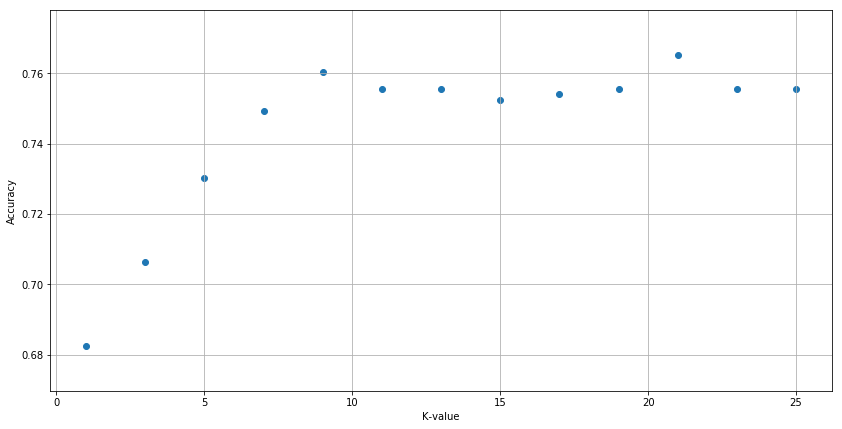

Accuracy of knn against test set with k_best: 0.7531380753138075


In [21]:
print(f"k value for highest accuracy: {kAccs[0]}")
print(f"k_best accuracy: {kAccs[1][kAccs[2]]}")
plt.grid()
plt.ylabel("Accuracy")
plt.xlabel("K-value")
plt.scatter(np.arange(1,26,2),kAccs[1])
plt.show()

print(f"Accuracy of knn against test set with k_best: {knn(trainset,testset,trainlabels,testlabels, kAccs[0])[1]}")

**Exercise e:** In the cell below, please include your code implementing and running logistic regression as described in the exam PDF.

In [23]:
np.random.seed(42)
# This function has been used from lecture slides
def logistic(x):
    return np.exp(x)/(1 + np.exp(x))

# This function has been used from lecture slides
def logistic_insample(X, y, w):
    N, num_feat = X.shape
    w = w.reshape(num_feat,1)
    E = 0
    for n in range(N):
        xn = X[n,:].reshape(num_feat,1)
        E += (1/N)*np.log(1/logistic(y[n]*np.matmul(w.T,xn)))
    return E[0,0]

# This function has been used from lecture slides
def logistic_gradient(X, y, w):
    N, num_feat = X.shape
    w = w.reshape(num_feat,1)    
    g = np.zeros(w.shape)
    
    for n in range(N):
        xn = X[n,:].reshape(num_feat,1)
        increment = ((-1/N)*y[n]*xn)*logistic(-y[n]*np.matmul(w.T,xn))
        g += increment
    return g

# This function has been used from lecture slides
def log_reg(Xorig, y, max_iter, grad_thr):       
    # X is an N by d data matrix of input values
    # y is a N by 1 matrix of target values -1 and 1
    num_pts, num_feat = Xorig.shape
    onevec = np.ones((num_pts,1))
    X = np.concatenate((onevec, Xorig), axis = 1)    
    dplus1 = num_feat + 1
        
    # Initialize learning rate for gradient descent
    learningrate = 0.1        
    
    # Initialize weights at time step 0    
    w = 0.1*np.random.randn(num_feat + 1).reshape(num_feat+1,1)
    
    # Compute value of logistic log likelihood
    value = logistic_insample(X,y,w)
    
    num_iter = 0  
    convergence = 0
    
    # Keep track of function values
    E_in = []
    
    while convergence == 0:
        num_iter = num_iter + 1                        

        # Compute gradient at current w      
        g = logistic_gradient(X,y,w)
       
        # Set direction to move       
        v = -g
                     
        # Update weights
        w_new = w + learningrate*v
       
        # Check for improvement: Compute in-sample error for new w
        cur_value = logistic_insample(X,y,w_new)
        if cur_value < value:
            w = w_new
            value = cur_value
            E_in.append(value)
            # Adaptive learning rate: Increase learning rate when things go well
            learningrate *=1.1
        else:
            # Adaptive learning rate: Decrease learning rate if no improvement
            learningrate *= 0.9   
            
        # Determine whether we have converged: Is gradient norm below
        # threshold, and have we reached max_iter?
         
        #g_norm = norm(g)
        g_norm = np.linalg.norm(g)
        #print(g_norm)
        if g_norm < grad_thr:
            convergence = 1
            print('converged')
        elif num_iter > max_iter:
            convergence = 1
            print('reached maximum nr of iterations')
           
    return w, E_in 

# This function has been used from lecture slides
def log_pred(Xorig, w):
    # X is a d by N data matrix of input values    
    num_pts, num_feat = Xorig.shape
    w = w.reshape(num_feat+1,1)    
    onevec = np.ones((num_pts,1))
    X = np.concatenate((onevec, Xorig), axis = 1)
    P = np.zeros(num_pts)
    for n in range(num_pts):
        xn = X[n,:].reshape(num_feat+1,1)   
        P[n] = logistic(np.matmul(w.T,xn)) # Probability of having label +1
        
    Pthresh = np.round(P) #0/1 class labels
    pred_classes = Pthresh*2-1
    return P, pred_classes

In [34]:
negTrainLabels = ((trainlabels-0.5)*2).reshape(trainlabels.shape[0],1)
negTestLabels = ((testlabels-0.5)*2).reshape(testlabels.shape[0],1)
wopt = log_reg(trainset, negTrainLabels, 100000, 0.5)[0]

def findAcc(accSet, labels, weights):
    N = accSet.shape[0]
    _, pred_classes = log_pred(accSet, weights)
    errors = np.sum(np.abs(pred_classes.reshape(N,1) - labels))/2
    return (N-errors)/N

print('Accuracy on training set:', findAcc(trainset, negTrainLabels, wopt))
print('Accuracy on test set:', findAcc(testset, negTestLabels, wopt))

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in true_divide
  del sys.path[0]


converged
Accuracy on training set: 0.6285714285714286
Accuracy on test set: 0.6234309623430963


**Exercise f:** In the cell below, please include your code implementing and running data centering and standardization, as well as re-running the classifiers from ecercises c) and e).

In [35]:
def center(centSet):
    return centSet-np.mean(centSet, axis=0)

def normalise(normSet):
    retSet = np.zeros(normSet.shape)
    for i in range(normSet.shape[1]):
        retSet[:,i] = (normSet[:,i] - min(normSet[:,i]))/(max(normSet[:,i]) - min(normSet[:,i]))
    return retSet

def preprocess(procSet):
    return center(normalise(procSet))

ppw = log_reg(preprocess(trainset), negTrainLabels, 100000, 0.01)[0]
ppKnn = knn(preprocess(trainset),testset,trainlabels,testlabels, kAccs[0])[1]
ppLogReg = findAcc(testset, negTestLabels, ppw)

converged


In [36]:
print(f"Accuracy of knn against test set with k_best: {ppKnn}")
print(f"Accuracy of logistic regression against test set: {ppLogReg}")

Accuracy of knn against test set with k_best: 0.5815899581589958
Accuracy of logistic regression against test set: 0.5815899581589958


In [ ]:
# This bit is just to visalise the dataset
# It doesn't really matter
for i in range(len(trainset)):
    plt.plot(trainset[i,:])
plt.show()